In [1]:
"""
Author: Qijia Huang
"""

from resnet20 import ResNetCIFAR
from train_util import *

import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision

import math
import os
import random
import sys
from matplotlib import pyplot as plt
import tqdm
import utils

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Load Data 

In [2]:
batch_size = 128

print('==> Preparing data..')
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print('Training data: ',len(trainset))
print('Test data: ',len(testset))

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Training data:  50000
Test data:  10000


In [3]:
version = 'v6'
images, labels = utils.load_new_test_data(version)
num_images = images.shape[0]
x = torch.Tensor(images).permute(0,3,1,2)/255

shiftset = torch.utils.data.TensorDataset(x,torch.Tensor(labels).to(torch.long))
shiftloader = torch.utils.data.DataLoader(shiftset, batch_size=100, shuffle=False, num_workers=2)


print('\nLoaded version "{}" of the CIFAR-10.1 dataset.'.format(version))
print('There are {} images in the dataset.'.format(num_images))

Loading labels from file /home/jovyan/work/distillation/data/cifar_v6/cifar10.1_v6_labels.npy
Loading image data from file /home/jovyan/work/distillation/data/cifar_v6/cifar10.1_v6_data.npy

Loaded version "v6" of the CIFAR-10.1 dataset.
There are 2000 images in the dataset.


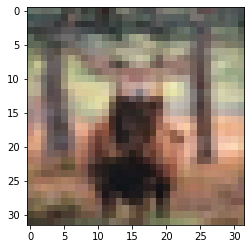

Class "deer"


In [4]:
cifar_label_names = utils.cifar10_label_names

image_index = random.randrange(num_images)
plt.figure()
plt.imshow(images[image_index,:,:,:])
plt.show()

print('Class "{}"'.format(cifar_label_names[labels[image_index]]))

In [5]:
cinic_directory = './data/CINIC-10'
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]
# cinic_train = torch.utils.data.DataLoader(
#     torchvision.datasets.ImageFolder(cinic_directory + '/train',
#         transform=transforms.Compose([transforms.ToTensor(),
#         transforms.Normalize(mean=cinic_mean,std=cinic_std)])),
#     batch_size=128, shuffle=True)
cinic_set = torchvision.datasets.ImageFolder(cinic_directory + '/valid', transform=transforms.Compose([transforms.ToTensor()]))
cinicloader = torch.utils.data.DataLoader(cinic_set, batch_size=100, shuffle=True)

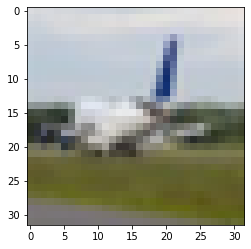

Class "airplane"


In [6]:
cifar_label_names = utils.cifar10_label_names

image_index = random.randrange(num_images)
plt.figure()
plt.imshow(cinic_set[image_index][0].permute(1,2,0))
plt.show()

print('Class "{}"'.format(cifar_label_names[cinic_set[image_index][1]]))

### Original model training

In [7]:
net = ResNetCIFAR()
net = net.to(device)

net.load_state_dict(torch.load("resnet_noaug.pt", map_location=device))


<All keys matched successfully>

In [14]:
net = ResNetCIFAR()
net = net.to(device)

log = train(net,trainloader,testloader,shiftloader, epochs=100, batch_size=128, lr=0.1, reg=10e-4, check_pt='resnet_ES.pt')


Epoch: 0
[Step=100]	Loss=1.8793	acc=0.2972	1891.0 examples/second
[Step=200]	Loss=1.6928	acc=0.3673	1742.0 examples/second
[Step=300]	Loss=1.5692	acc=0.4156	1659.0 examples/second
Test Loss=1.6427, Test acc=0.4248
Saving...
Shift Loss=1.9371, Shift acc=0.3390

Epoch: 1
[Step=400]	Loss=1.1797	acc=0.5885	1119.3 examples/second
[Step=500]	Loss=1.0638	acc=0.6148	1918.0 examples/second
[Step=600]	Loss=1.0282	acc=0.6284	1882.9 examples/second
[Step=700]	Loss=0.9880	acc=0.6433	1715.9 examples/second
Test Loss=1.2053, Test acc=0.5696
Saving...
Shift Loss=1.5946, Shift acc=0.4540

Epoch: 2
[Step=800]	Loss=0.8040	acc=0.7166	1130.5 examples/second
[Step=900]	Loss=0.8258	acc=0.7088	1772.1 examples/second
[Step=1000]	Loss=0.8178	acc=0.7112	1950.5 examples/second
[Step=1100]	Loss=0.8086	acc=0.7159	1942.6 examples/second
Test Loss=1.1538, Test acc=0.5922
Saving...
Shift Loss=1.5454, Shift acc=0.4695

Epoch: 3
[Step=1200]	Loss=0.7431	acc=0.7468	1263.9 examples/second
[Step=1300]	Loss=0.7190	acc=0.750

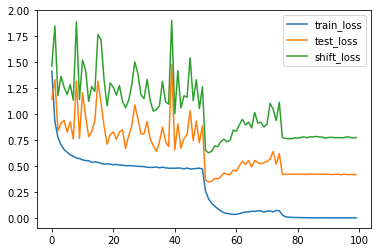

In [30]:
plt.plot(read_log[0],label='train_loss')
plt.plot(read_log[1],label='test_loss')
plt.plot(read_log[2],label='shift_loss')
plt.legend(loc="upper right")

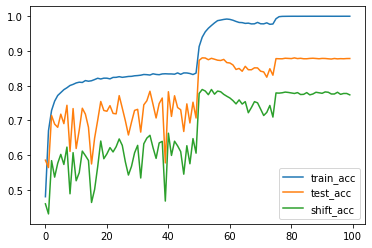

In [31]:
plt.plot(read_log[3],label='train_acc')
plt.plot(read_log[4],label='test_acc')
plt.plot(read_log[5],label='shift_acc')
plt.legend(loc="lower right")

In [28]:
np.savetxt('noaug_model_train_log.csv', log, delimiter=',')

In [29]:
read_log = np.loadtxt('noaug_model_train_log.csv', delimiter=',')
print(read_log.shape)

(6, 100)


In [33]:
test(net,testloader,shiftloader)

tensor([[3.2982e-06, 6.0062e-06, 4.8808e-06, 9.9932e-01, 2.7929e-06, 5.6072e-04,
         9.1688e-05, 2.9807e-06, 4.4692e-06, 2.8247e-06],
        [1.1133e-04, 6.4306e-04, 2.5808e-07, 2.9008e-07, 7.9942e-08, 4.2029e-08,
         7.6661e-07, 1.0478e-07, 9.9923e-01, 1.3662e-05],
        [5.3710e-03, 9.0575e-01, 6.1084e-04, 7.1818e-04, 1.1202e-04, 2.6451e-04,
         4.8979e-04, 3.5962e-04, 8.5053e-02, 1.2721e-03],
        [7.8344e-01, 1.9013e-02, 4.9834e-03, 1.8011e-02, 8.5233e-04, 1.0065e-03,
         1.5147e-03, 1.1940e-03, 4.3495e-02, 1.2649e-01],
        [1.2417e-04, 2.2937e-04, 9.3264e-03, 4.3757e-03, 1.9750e-03, 1.9148e-04,
         9.8340e-01, 5.5946e-05, 2.0605e-04, 1.2058e-04],
        [2.9678e-06, 5.9965e-06, 5.0401e-05, 1.5852e-02, 5.3573e-04, 6.3424e-03,
         9.7712e-01, 7.8407e-05, 4.4547e-06, 7.7918e-06],
        [1.8408e-05, 9.9346e-01, 5.6165e-06, 7.9695e-05, 1.3506e-06, 2.6665e-05,
         1.1219e-05, 3.0289e-06, 3.3645e-06, 6.3916e-03],
        [8.5136e-04, 6.6002

In [8]:
teacher = ResNetCIFAR()
teacher.to(device)
teacher.load_state_dict(torch.load("resnet_noaug.pt", map_location=device))

student = ResNetCIFAR()
student = student.to(device)


In [9]:
trainKD(student,teacher,trainloader,testloader, epochs=100, batch_size=128, lr=0.1, reg=10e-4, check_pt='resnet_KD_noaug_teacher.pt')


Epoch: 0
tensor([[2.0066e-03, 3.3139e-04, 4.5461e-05, 1.1325e-05, 3.2349e-06, 1.1423e-06,
         1.2953e-05, 4.7120e-06, 9.9757e-01, 1.1926e-05],
        [9.9977e-01, 1.2594e-05, 6.7817e-06, 1.0200e-05, 5.7623e-07, 3.1191e-07,
         3.5853e-07, 8.8749e-07, 5.4398e-06, 1.8782e-04],
        [1.3544e-05, 2.6967e-06, 5.8664e-03, 9.7876e-01, 1.4023e-02, 6.7318e-04,
         6.0639e-04, 4.3305e-05, 7.2317e-06, 6.0269e-06],
        [2.4734e-04, 4.8879e-04, 1.0594e-03, 7.9355e-01, 1.0467e-03, 1.5976e-01,
         1.4828e-02, 2.8540e-02, 1.7713e-04, 3.0387e-04],
        [2.4696e-05, 5.7017e-06, 3.4273e-07, 5.8958e-07, 4.7058e-07, 7.8270e-08,
         1.0207e-06, 2.4473e-07, 9.9997e-01, 1.7667e-06],
        [4.4352e-06, 9.9991e-01, 1.6104e-07, 3.1656e-07, 3.2158e-08, 1.8200e-07,
         3.2399e-07, 8.4429e-08, 7.6281e-06, 7.4463e-05],
        [9.3216e-01, 1.1820e-03, 5.2497e-02, 1.2044e-03, 1.0461e-03, 2.0503e-04,
         4.0902e-04, 3.3980e-03, 4.9680e-03, 2.9281e-03],
        [9.4471e-

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


[Step=100]	Loss=0.8757	acc=0.3455	1146.8 examples/second
[Step=200]	Loss=0.7417	acc=0.4155	1270.8 examples/second
[Step=300]	Loss=0.6609	acc=0.4660	1385.5 examples/second
Test Loss=1.3475, Test acc=0.6119
Saving...

Epoch: 1
[Step=400]	Loss=0.3745	acc=0.6458	967.6 examples/second
[Step=500]	Loss=0.3664	acc=0.6664	1242.3 examples/second
[Step=600]	Loss=0.3462	acc=0.6854	1296.6 examples/second
[Step=700]	Loss=0.3303	acc=0.6980	1278.5 examples/second
Test Loss=1.2244, Test acc=0.6938
Saving...

Epoch: 2
[Step=800]	Loss=0.2520	acc=0.7617	976.1 examples/second
[Step=900]	Loss=0.2428	acc=0.7677	1352.8 examples/second
[Step=1000]	Loss=0.2370	acc=0.7752	1299.8 examples/second
[Step=1100]	Loss=0.2334	acc=0.7760	1319.8 examples/second
Test Loss=1.1911, Test acc=0.6688

Epoch: 3
[Step=1200]	Loss=0.2036	acc=0.8116	1006.2 examples/second
[Step=1300]	Loss=0.1985	acc=0.8126	1312.6 examples/second
[Step=1400]	Loss=0.1988	acc=0.8101	1290.8 examples/second
[Step=1500]	Loss=0.1995	acc=0.8094	1275.2 examp

In [10]:
student = ResNetCIFAR()
student = student.to(device)
student.load_state_dict(torch.load('resnet_KD_noaug_teacher.pt',map_location=device))

basemodel = ResNetCIFAR()
basemodel = basemodel.to(device)
basemodel.load_state_dict(torch.load('resnet_noaug.pt',map_location=device))



<All keys matched successfully>

In [12]:
test(basemodel,testloader,cinicloader)
test(student,testloader,cinicloader)

Testset Loss=0.3514, Testset test accuracy=0.8801
Shiftset Loss=1.0229, Shiftset test accuracy=0.6979
Testset Loss=0.8125, Testset test accuracy=0.8908
Shiftset Loss=1.1786, Shiftset test accuracy=0.7121


In [11]:
test(basemodel,testloader,shiftloader)
test(student,testloader,shiftloader)

Testset Loss=0.3514, Testset test accuracy=0.8801
Shiftset Loss=0.6314, Shiftset test accuracy=0.7890
Testset Loss=0.8125, Testset test accuracy=0.8908
Shiftset Loss=1.0555, Shiftset test accuracy=0.7945
